In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from analyzer.metric import MetricCalculator
from analyzer.model.regression_model import RegressionModel
from data.io import Reader
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from keras.src.layers import Dense
from keras import Sequential, Input

# Постановка задачи
1. Провести анализ датасета 
2. Построить модель для предсказания price

датасет:
https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv

# Проверка целостности датасета

In [2]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv")
df = df_original.copy().reset_index(drop=True)
df.head(10)

price        cost  sales  profit_margin  inventory  \
0  316.869950  161.477566     48      49.039798        165   
1  131.647256  100.548118     35      23.623082         81   
2  271.678142  157.859414     45      41.894695         45   
3  173.132000  106.068699     37      38.735358        140   
4  337.336676  293.972797      3      12.854778        127   
5  234.200303  172.859762     26      26.191487        175   
6  408.782915  341.107710     32      16.555292         52   
7  181.053113  142.865894      9      21.091722        168   
8  265.631845  218.395313     46      17.782707         32   
9  418.578581  367.637518     45      12.170012         31   

   discount_percentage  delivery_days category material  color  location  \
0            19.378928              2     Desk    Metal  Black     Rural   
1            25.242493              2    Chair    Metal    Red     Rural   
2            10.691594              9     Sofa     Wood  Brown     Urban   
3             0.244387              7    Chair  Plastic    Red  Suburban   
4            20.893134              9     Desk  Plastic  White     Urban   
5            11.574376              4    Table   Fabric  White     Rural   
6            21.058416              1    Table    Metal  Green     Urban   
7             9.398280              9      Bed   Fabric  Green     Rural   
8            12.652649              1    Table    Glass    Red     Urban   
9             8.540232              4      Bed    Metal   Blue     Rural   

   season store_type   brand       revenue  
0  Spring     Online  BrandD  16499.290702  
1  Spring     Retail  BrandA   5044.225701  
2  Spring     Retail  BrandD  13311.236484  
3  Winter     Online  BrandD  12116.169102  
4  Spring     Retail  BrandA   7790.163993  
5  Winter     Retail  BrandD   8064.196793  
6  Spring     Retail  BrandD  13057.839237  
7  Summer     Online  BrandC   4191.031416  
8  Winter     Retail  BrandA   8551.770855  
9  Summer     Retail  BrandA  20369.398994

In [3]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [4]:
# посмотрим на пропуски в данных
df.isna().sum()

price                  0
cost                   0
sales                  0
profit_margin          0
inventory              0
discount_percentage    0
delivery_days          0
category               0
material               0
color                  0
location               0
season                 0
store_type             0
brand                  0
revenue                0
dtype: int64

In [5]:
# Посмотрим статистику о датасете
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

# Оптимизируем датасет

In [6]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [7]:
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

In [8]:
df['sales'] = df['sales'].astype('uint8')
df['inventory'] = df['inventory'].astype('uint8')
df['delivery_days'] = df['delivery_days'].astype('uint8')

In [9]:
# проверяем
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   uint8  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   uint8  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   uint8  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), object(7), uint8(3)
mem

Выводы:
1. float данные не удаётся преобразовать менее, чем float64
2. int данные удаётся конвертировать в uint8 (без отрицательных значений)

# Проводим первичный визуальный анализ зависимостей данных

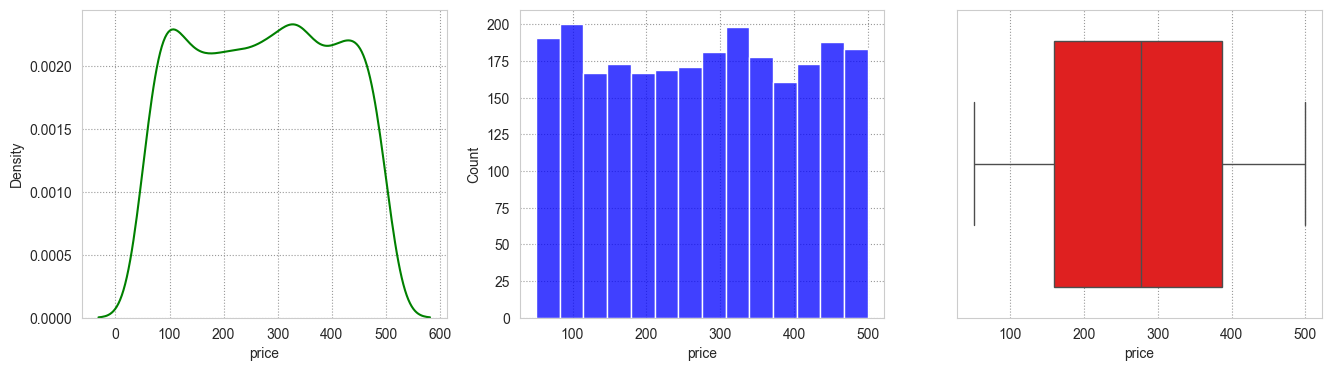

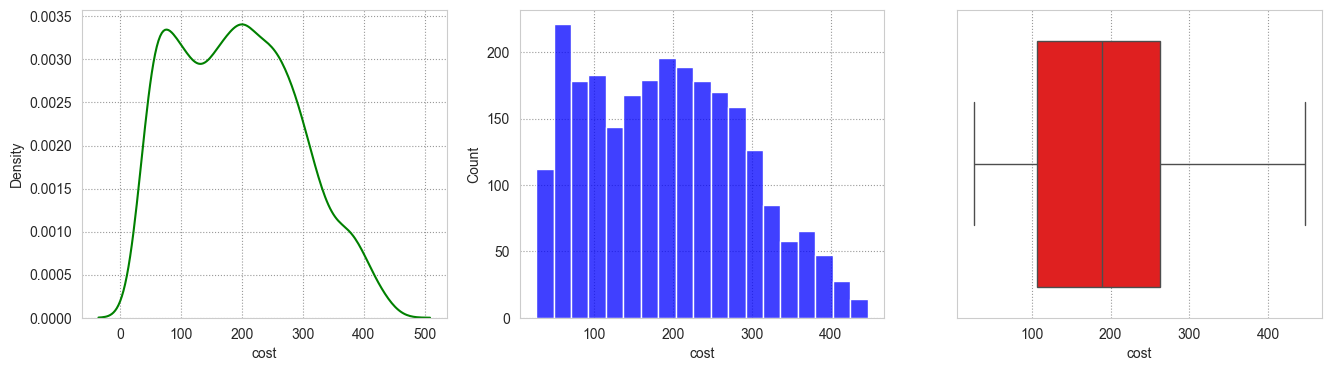

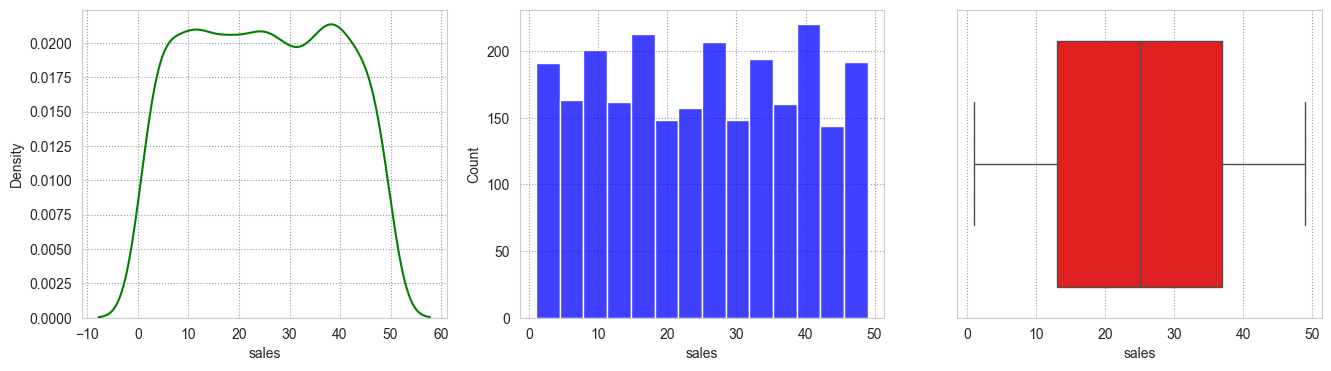

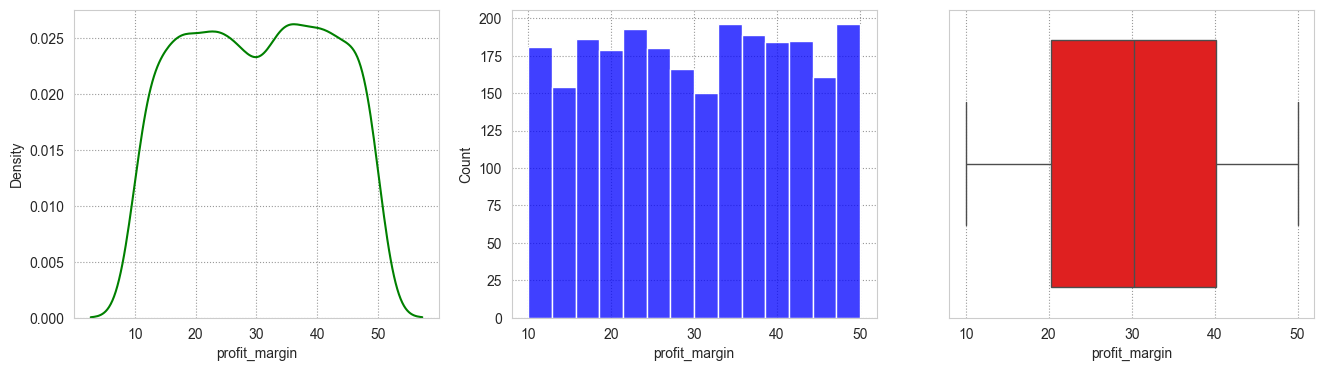

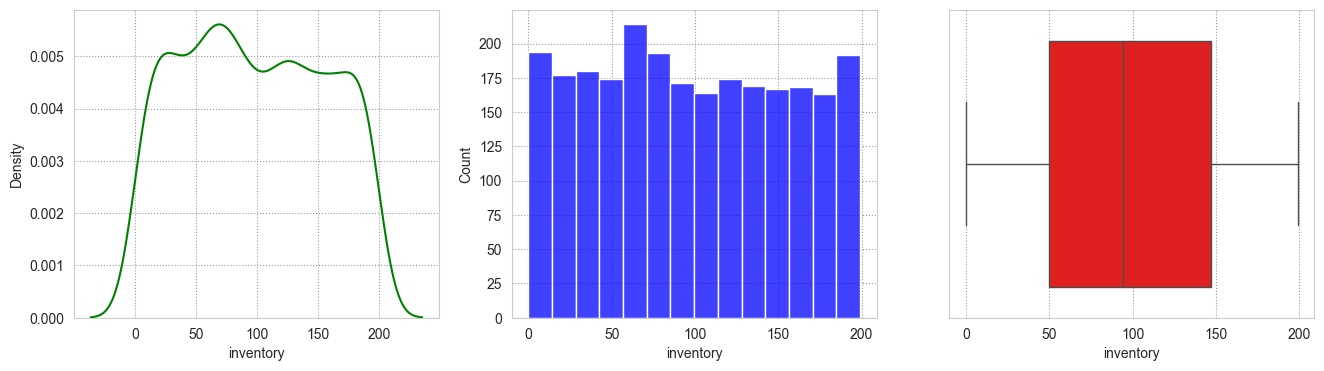

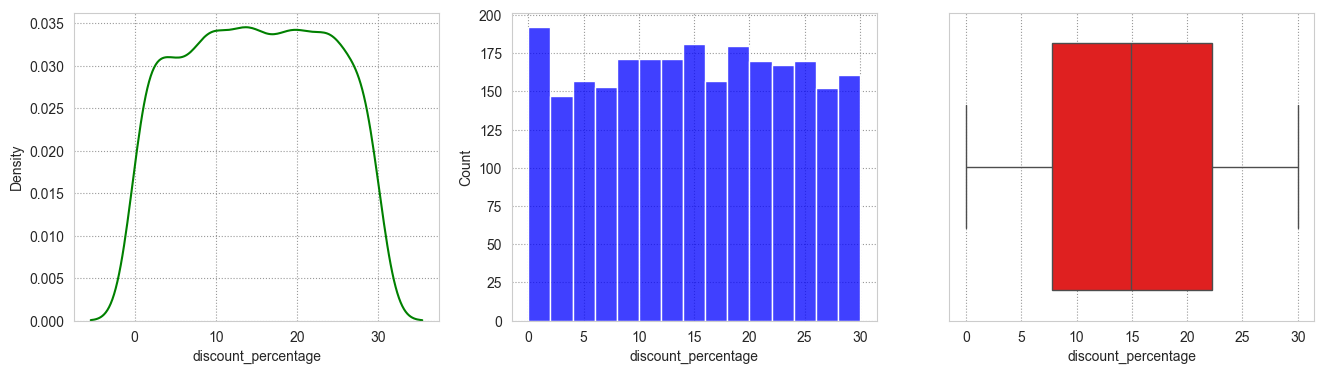

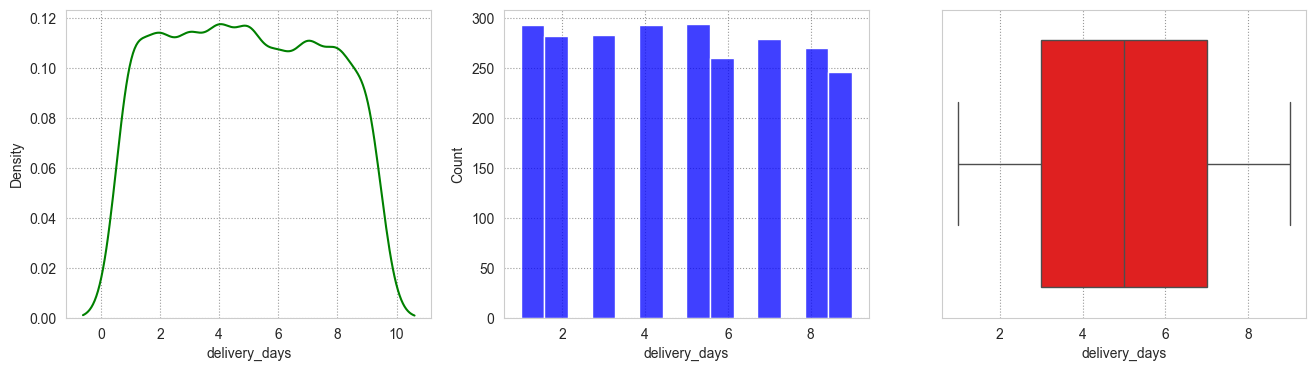

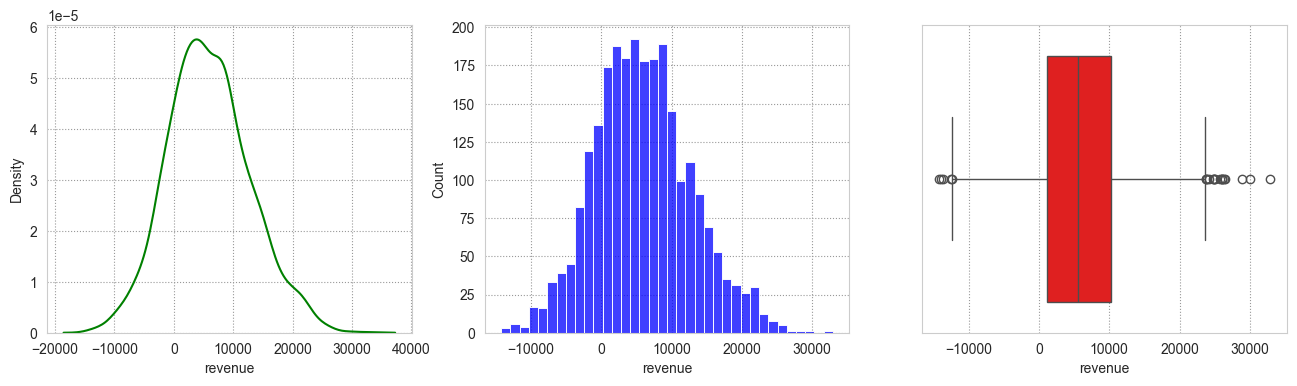

In [11]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

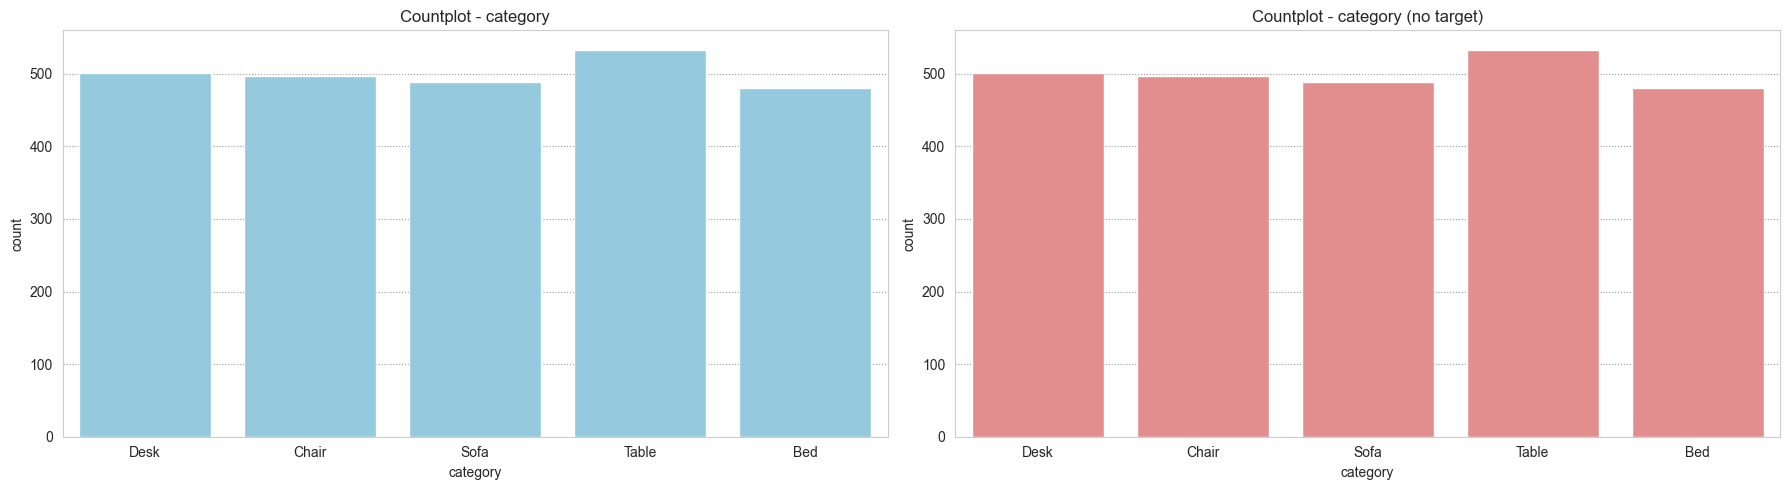

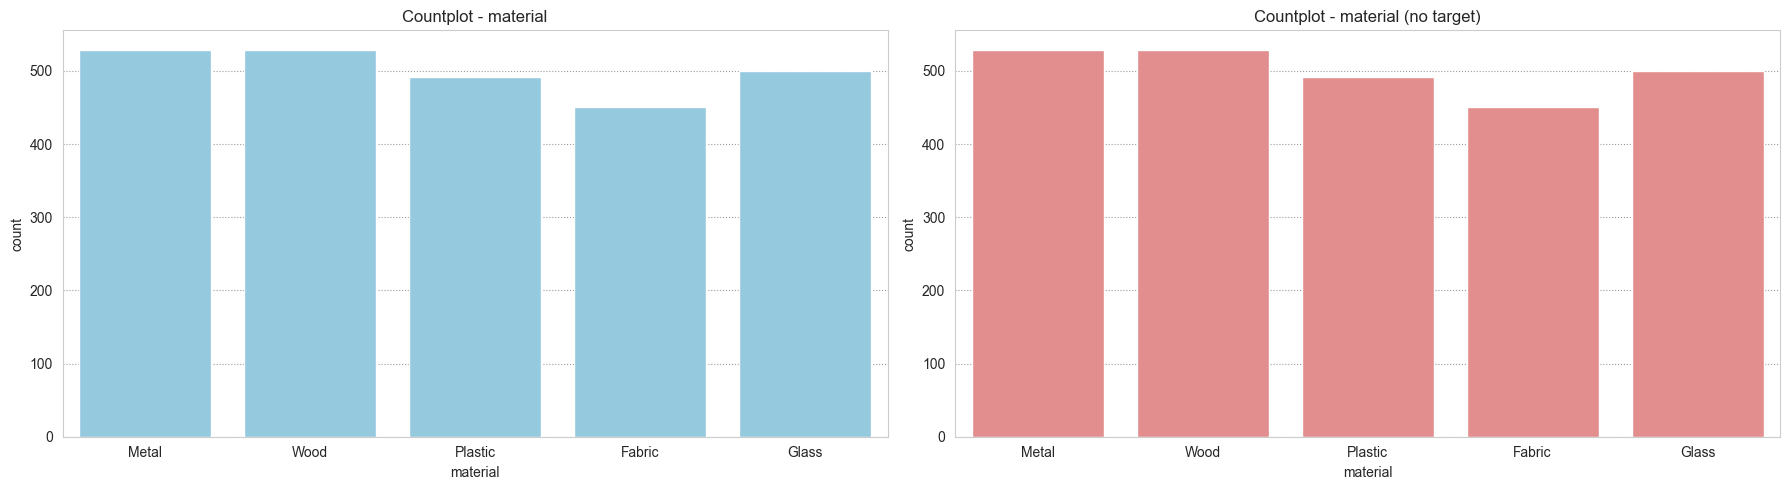

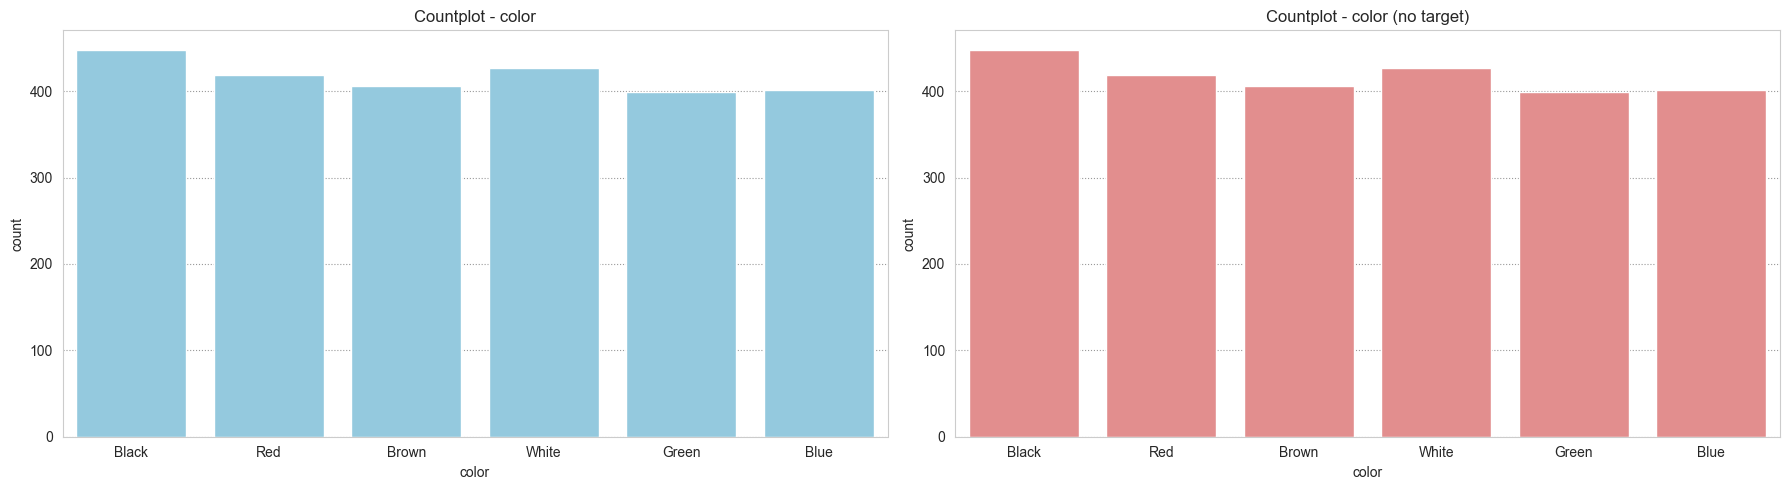

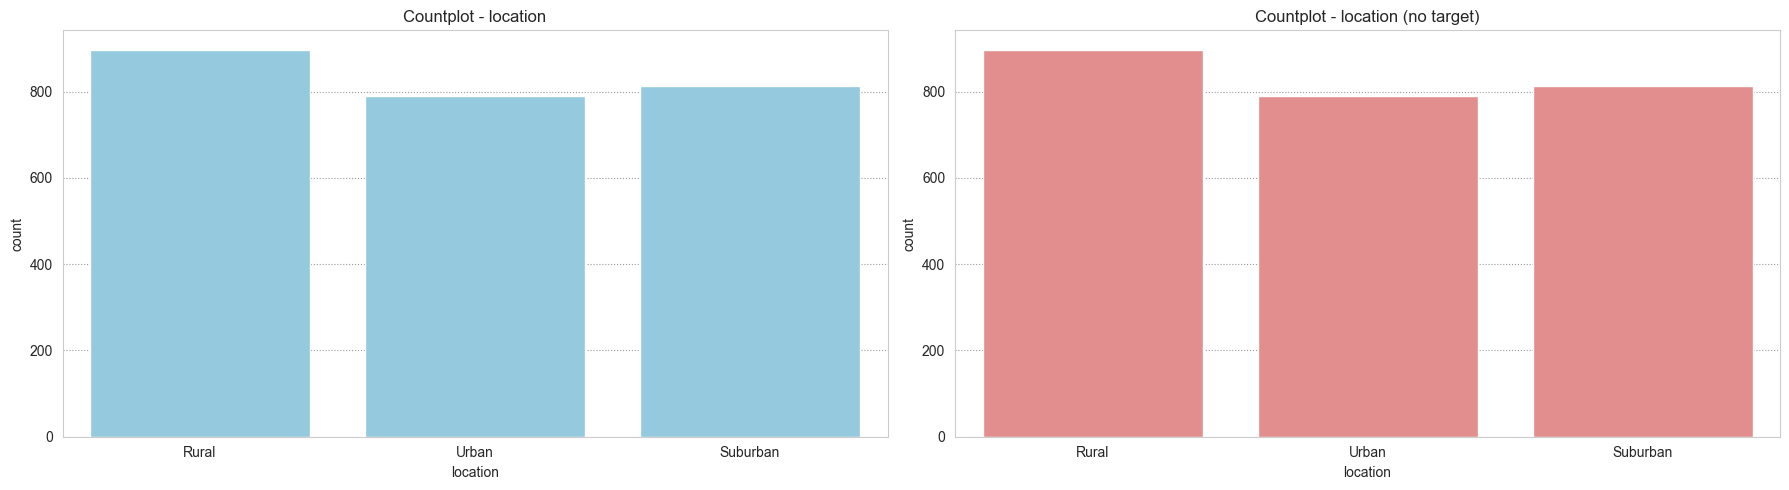

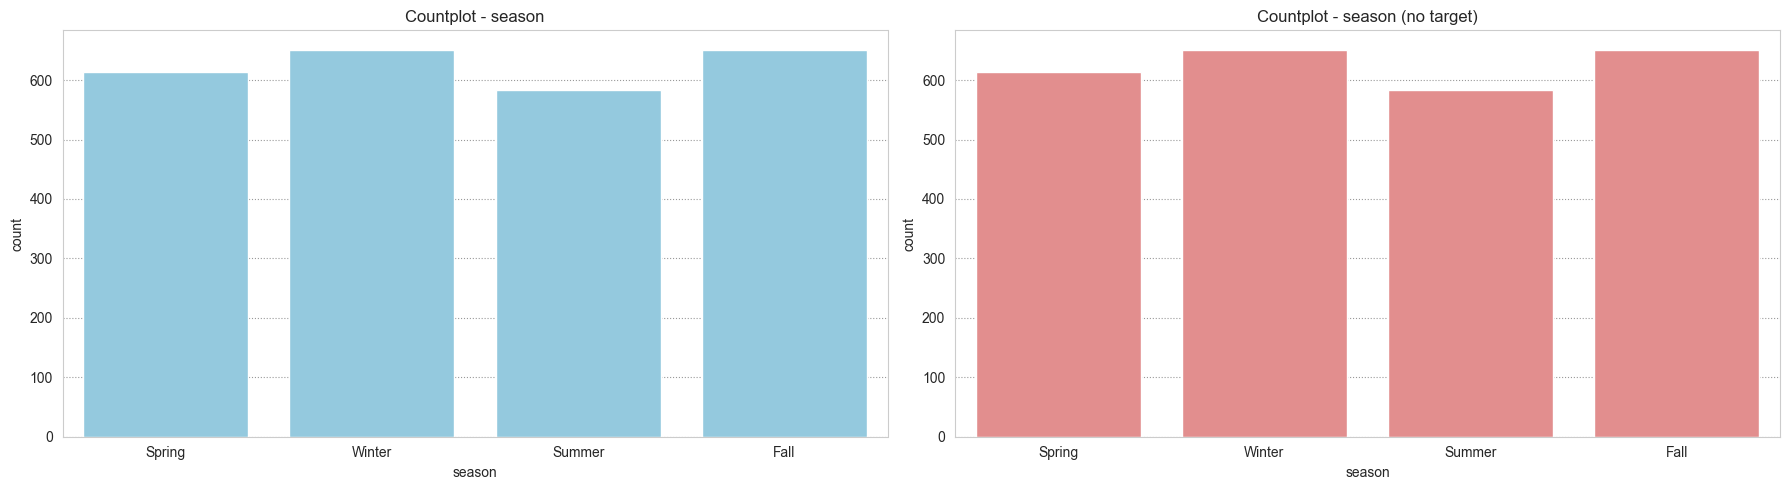

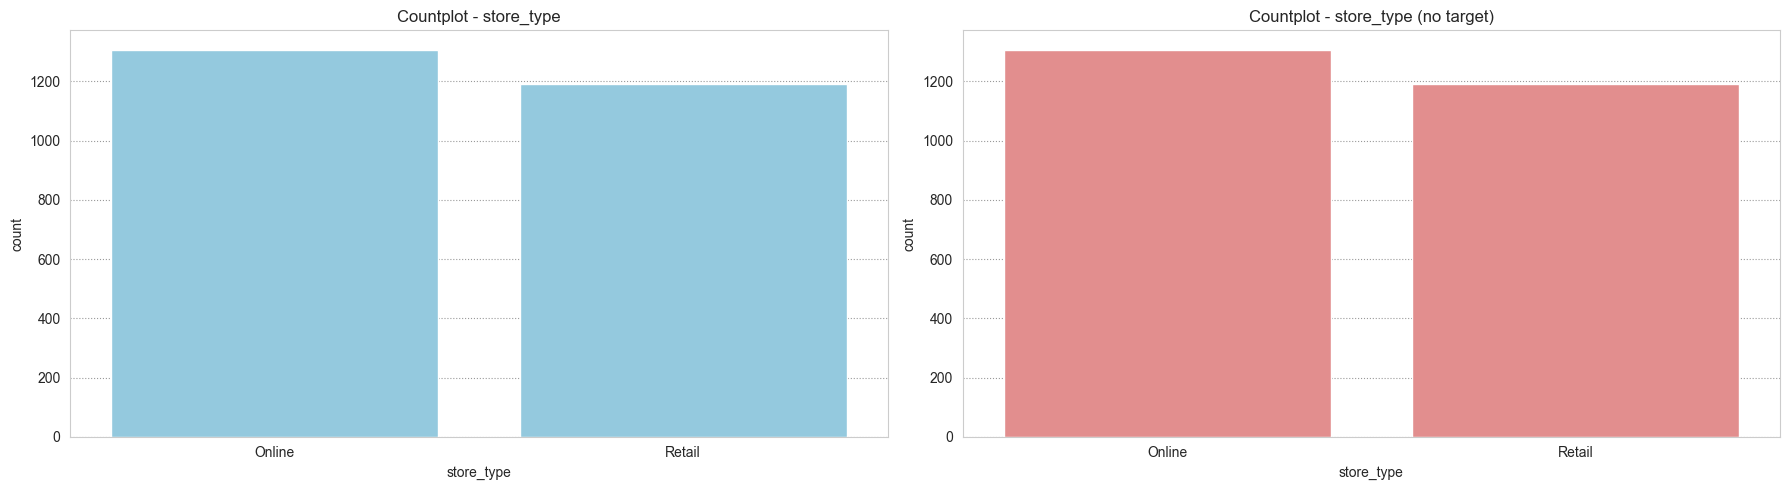

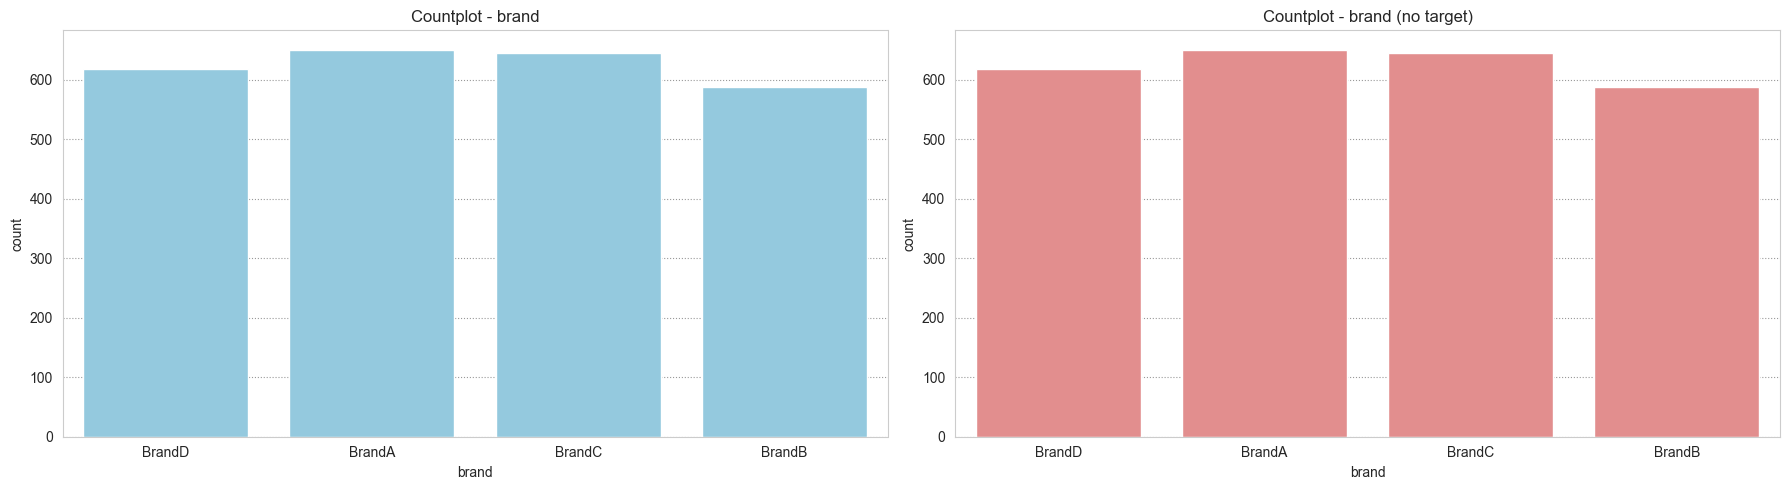

In [12]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

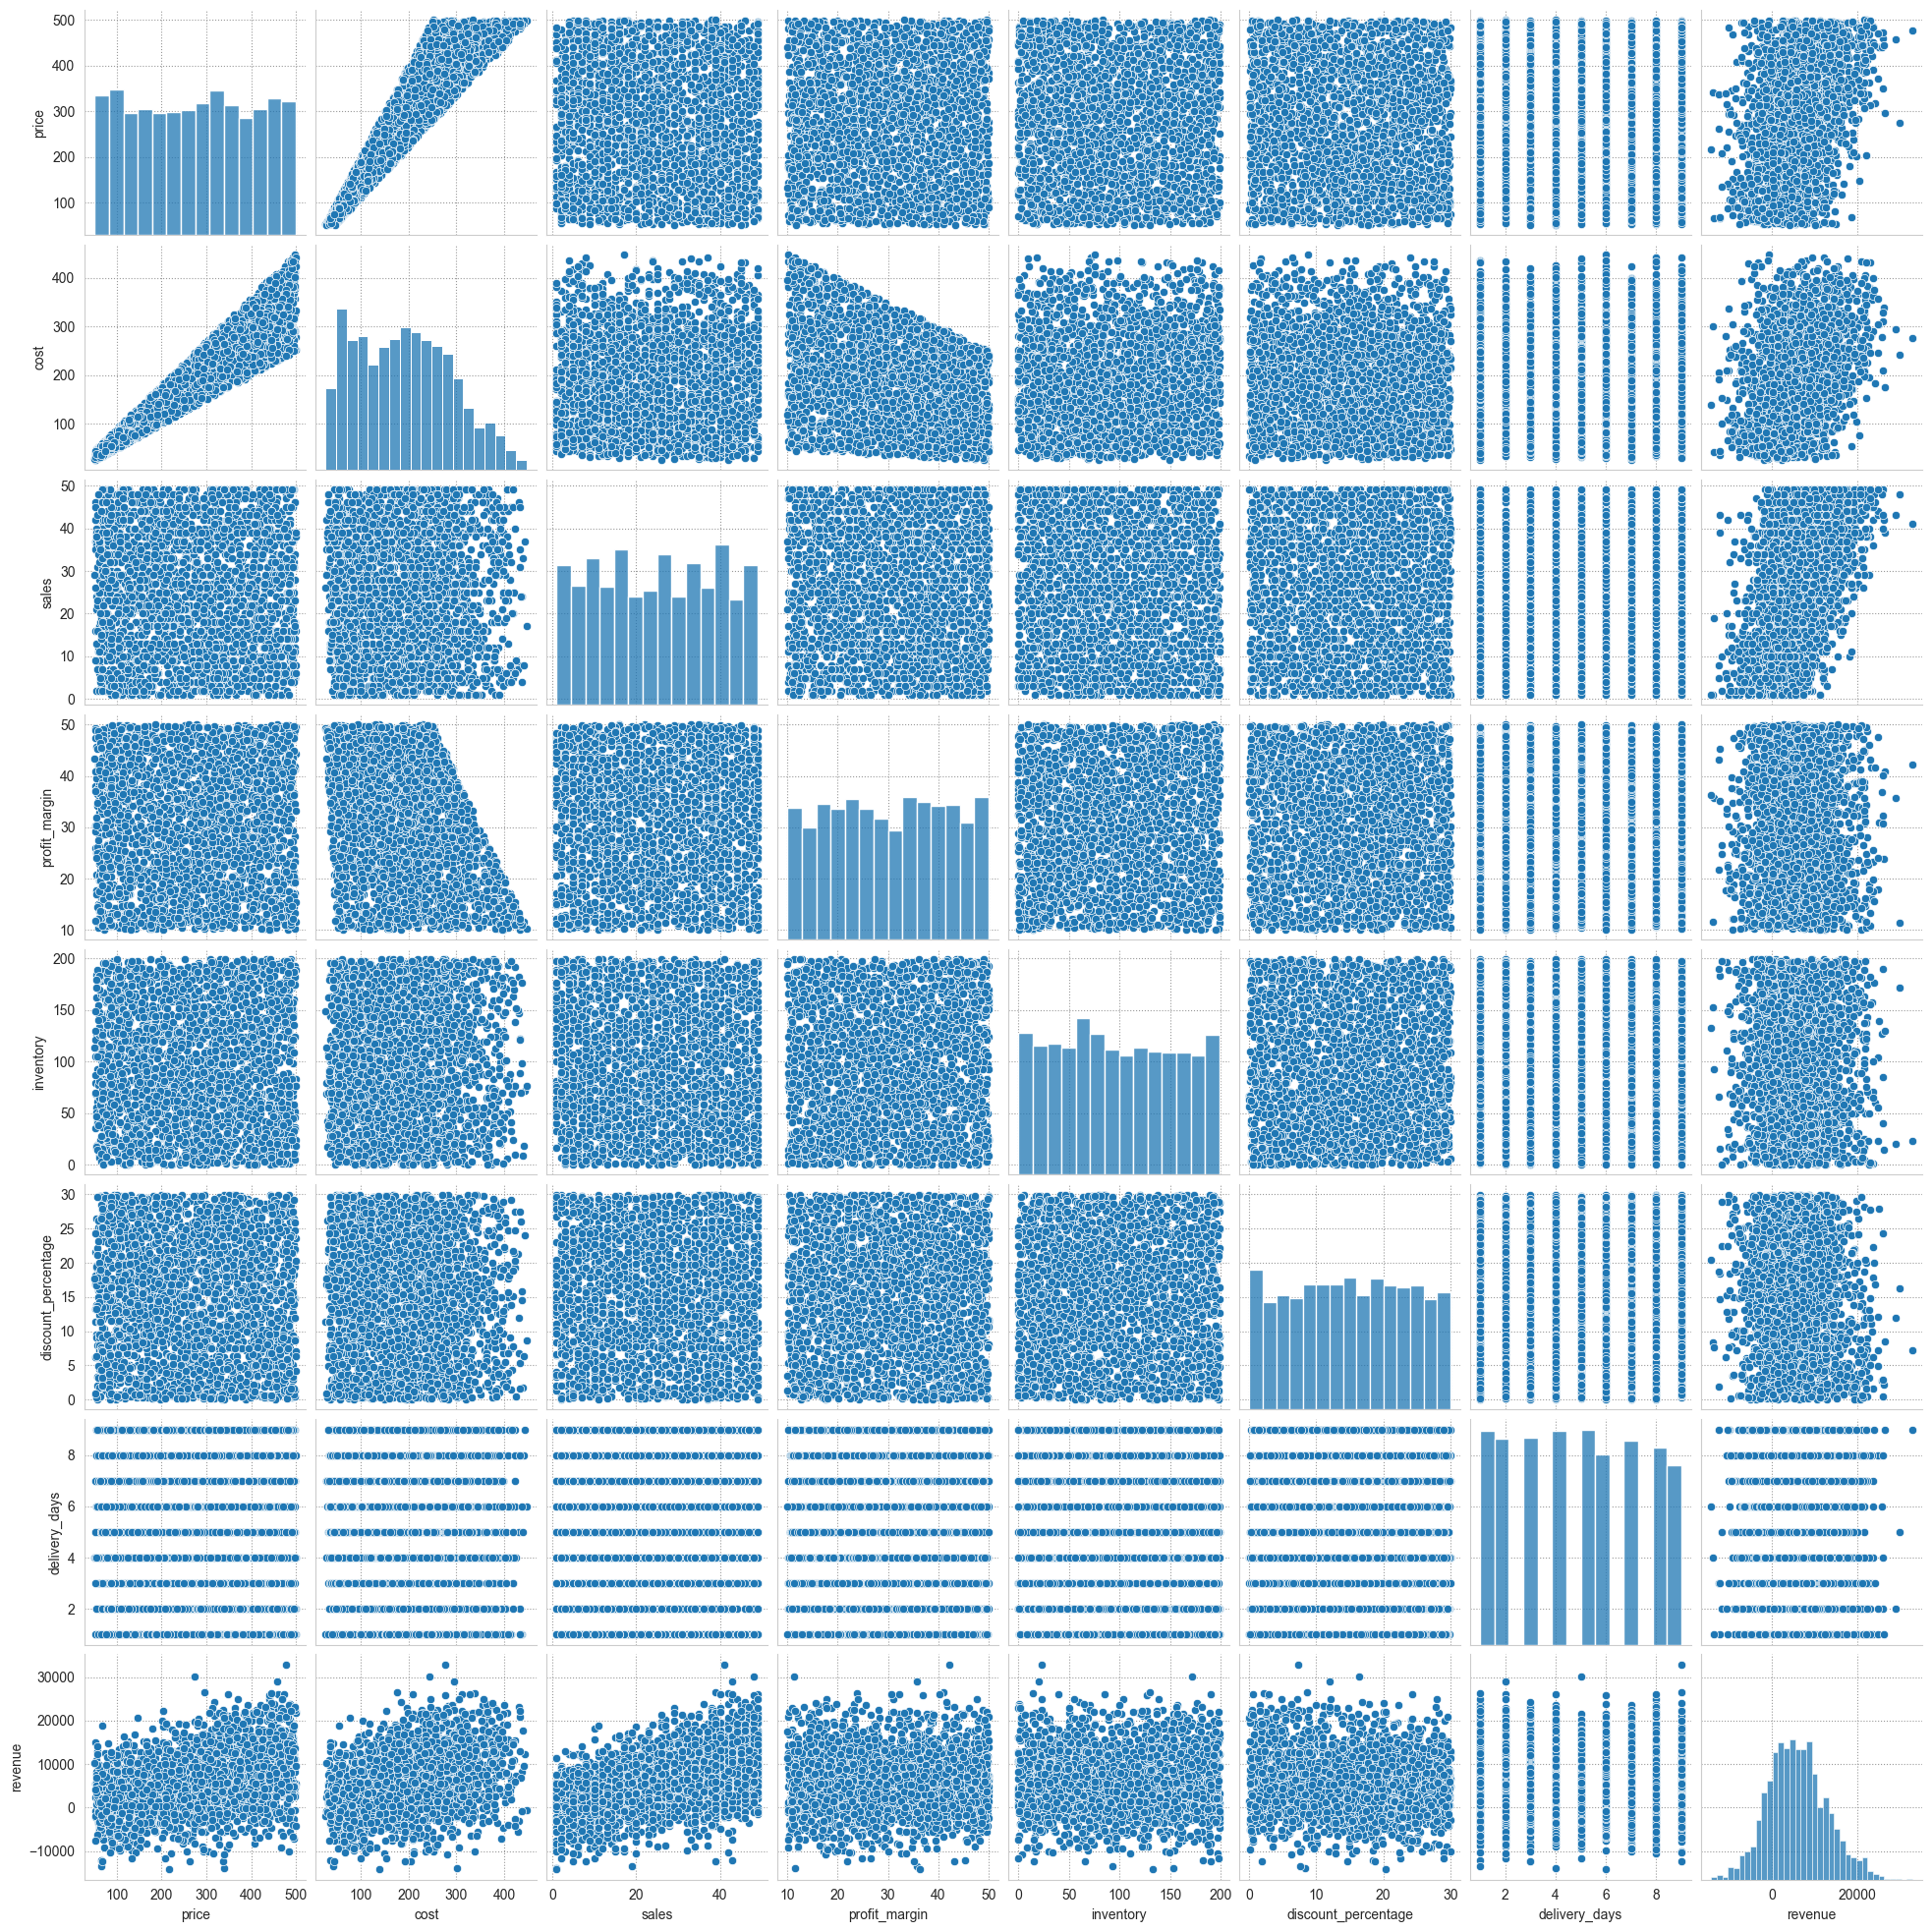

In [13]:
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

Выводы:
1. cost и revenue имеют близкое к нормальному распределению
2. выше определённого значения cost начинает падает profit_margin
3. подозрения на прямую корреляцию price (таргета) от cost
4. распределения price и cost не равны 

# Проводим оценку зависимостей

## стат.обработка непрерывных данных

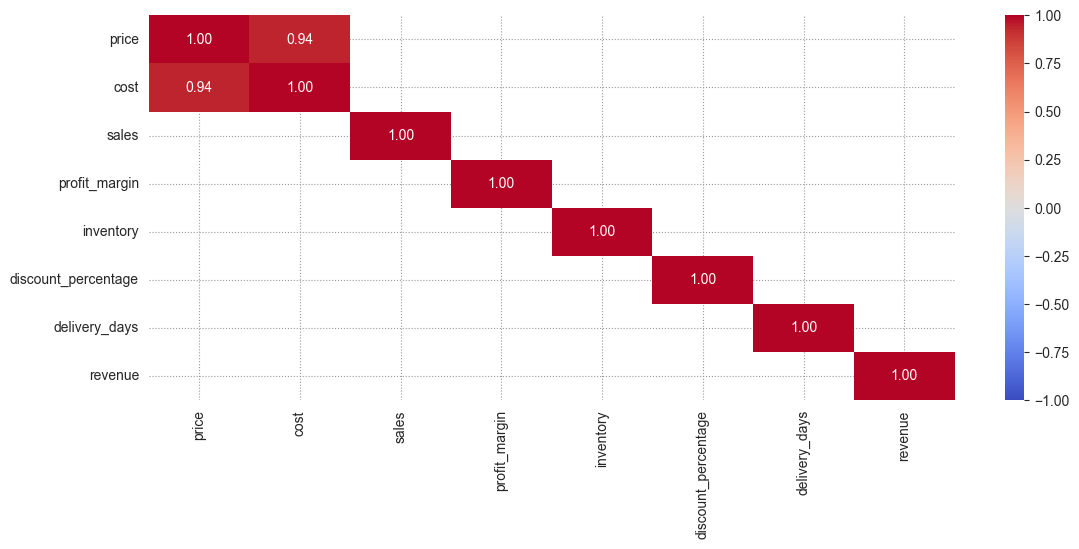

In [14]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(df, method='spearman', boundary=0.5)

In [30]:
# проверяем распределения между таргетом и признаками
for column in df.select_dtypes(include='number').columns:
    print(f"\n{column} и price:")
    groups = [df[column], df['price']]
    StatCriteria().mannwhitneyu(groups)


price и price:
Mann-Whitney U test
U_statistic = 3125000.000
Распределения двух выборок равны (p-value = 1.000).

cost и price:
Mann-Whitney U test
U_statistic = 1987986.000
Распределения двух выборок не равны (p-value = 0.000).

sales и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).

profit_margin и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).

inventory и price:
Mann-Whitney U test
U_statistic = 778193.000
Распределения двух выборок не равны (p-value = 0.000).

discount_percentage и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).

delivery_days и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).

revenue и price:
Mann-Whitney U test
U_statistic = 4972244.000
Распределения двух выборок не равны (p-value = 0.000).


In [16]:
# Проверим допущение о мультиколлинеарности признаков
exclude_features = ['price']
StatCriteria().VIF(df, exclude_features)

VIF
cost                 4.416676
sales                4.864945
profit_margin        5.206018
inventory            3.584181
discount_percentage  3.675485
delivery_days        4.153730
revenue              2.707721

Выводы:
1. сильная положительная корреляция price и cost
2. profit_margin с VIF > 5 намекает на некоторую мультиколлениарность
3. распределения непрерывных признаков и таргета не совпадают

## стат.обработка категориальных данных

In [17]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

category material  color location  season store_type   brand
count      2500     2500   2500     2500    2500       2500    2500
unique        5        5      6        3       4          2       4
top       Table    Metal  Black    Rural  Winter     Online  BrandA
freq        533      529    448      897     651       1307     650

Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 17.471, dof = 20.000
Две переменные независимы (p-value = 0.622).
Chi-square test
chisq_statistic = 5.572, dof = 8.000
Две переменные независимы (p-value = 0.695).
Chi-square test
chisq_statistic = 17.272, dof = 12.000
Две переменные независимы (p-value = 0.140).
Chi-square test
chisq_statistic = 7.275, dof = 4.000
Две переменные независимы (p-value = 0.122).
Chi-square test
chisq_statistic = 10.448, dof = 12.000
Две переменные независимы (p-value = 0.577).
Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 27.980, dof = 20.000
Две переменные независимы (p-value = 0.110).
Chi-square test
chisq_statistic = 13.374, dof = 8.000
Две переменные независимы (p-value = 0.100).
Chi-square test
chisq_statistic = 7.905, dof = 12.000
Две переменные независимы (p-value = 0.793).
Chi-sq

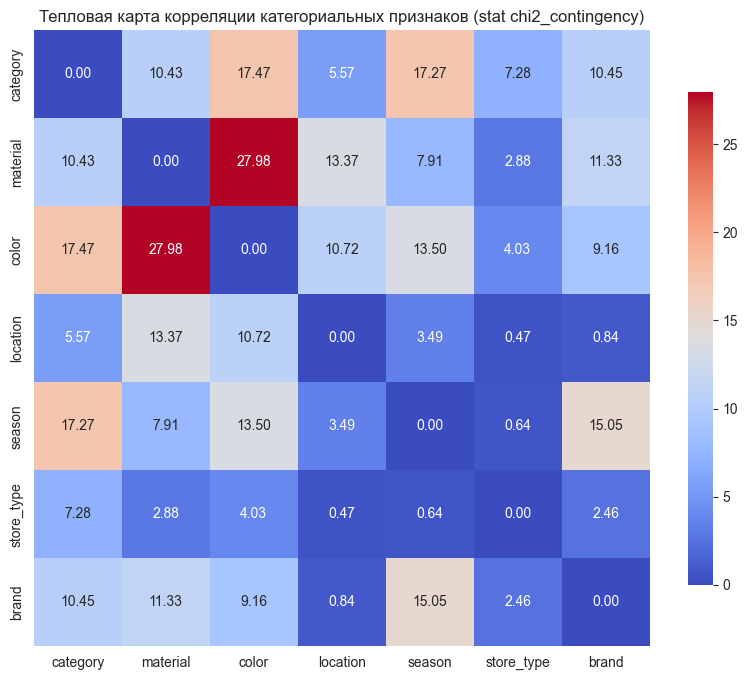

In [18]:
# Построим тепловую карту с категориальными переменными по хи-квадрат
Drawer.plot_heatmap_category(df)

Выводы:
1. небольшая зависимость категориальных признаков color и material
2. в категориальных данных нет большого числа уникальных значений
3. нет порядковых категориальных данных
4. store_type имеет два уникальных значения, можно использовать бинарную кодировку
5. season имеет циклические значения времён кода - циклическую кодировку
6. category, material, color, location, brand - подходят под one hot encoder

# Подготавливаем данные

In [19]:
# кодируем данные общего датасета
Encoder.booleanOneColumnEncoder(df['store_type'], 'Online')

0       1
1       0
2       0
3       1
4       0
       ..
2495    1
2496    0
2497    0
2498    0
2499    1
Name: store_type, Length: 2500, dtype: uint8

In [20]:
# разделяем данные
target = ['price']
exclude_features = ['price']
# exclude_features = ['price', 'profit_margin']  ## VIF profit_margin = 5.2

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

X_train, X_test, _ = Encoder.targetEncoder(X_train, X_test, y_train, columns_for_encoding)

# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

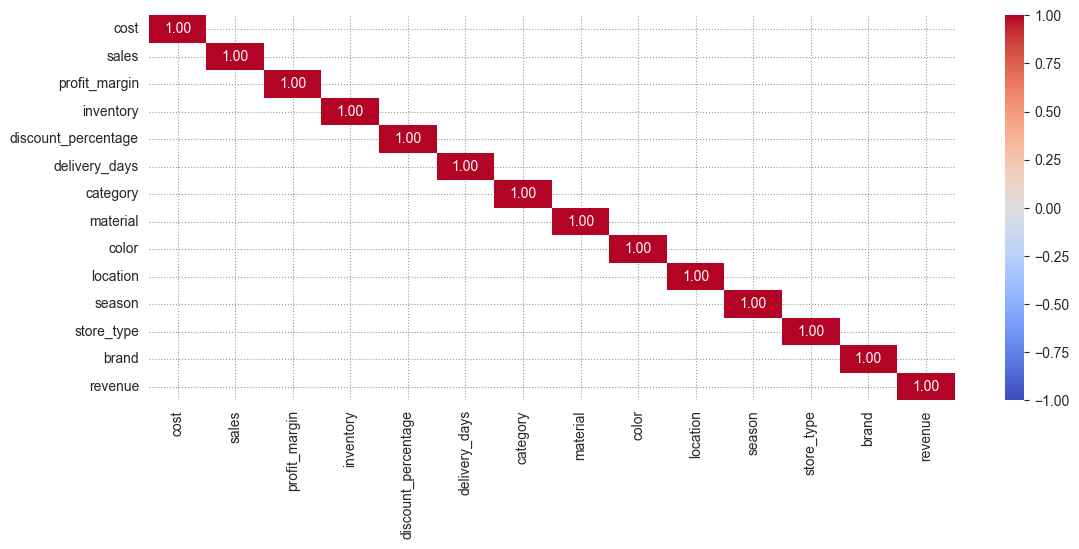

In [21]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(X_train, method='spearman', boundary=0.5)

In [22]:
# Применим метод Lasso для оценки признаков
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

__________
Коэффициенты Lasso-регрессии:
                Feature  Coefficient
0                  cost   581.324446
1                 sales    -2.714517
2         profit_margin   156.490637
3             inventory     0.156602
4   discount_percentage     1.149067
5         delivery_days    -1.755486
6              category     0.702874
7              material     0.732143
8                 color    -0.520259
9              location     0.270495
10               season     1.852856
11           store_type     0.527537
12                brand     1.467768
13              revenue    15.729791
R²: 0.972
MAE: 16.63
MAPE: 11%
RMSE: 22
MSE: 480


Выводы:
1. кодировка произведена
2. тепловая карта корреляции после кодировки в порядке

In [23]:
# разделяем данные
target = ['price']
exclude_features = ['price']
# exclude_features = ['price', 'profit_margin']

df_copy = df.copy().reset_index(drop=True)
df_copy['price'] = df_copy['price']/1_000

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df_copy, exclude_features, target)

# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

X_train, X_test, _ = Encoder.oneHotEncoder(X_train, X_test, columns_for_encoding)

# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

# Находим модель

## линейная регрессия

In [24]:
# Применим метод OLS
y_test, y_pred, model_lr = RegressionModel().OLS(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2350.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:30:35   Log-Likelihood:                 4550.9
No. Observations:                1875   AIC:                            -9042.
Df Residuals:                    1845   BIC:                            -8876.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cost                    0.5809    

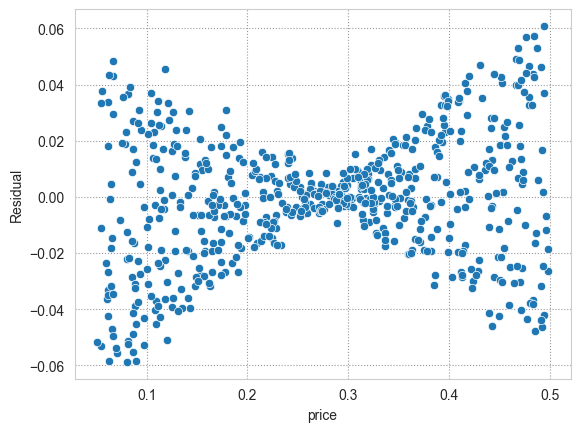

Shapiro-Wilk Test
statistic = 0.991
Данные не соответствуют нормальному распределению (p-value = 0.001).


In [25]:
# Проверка на гомоскедастичность визуально
residuals = y_test - y_pred
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()
StatCriteria().shapiro(residuals)

## метод опорных векторов

In [26]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.970
MAE: 0.02
MAPE: 9%
RMSE: 0
MSE: 0


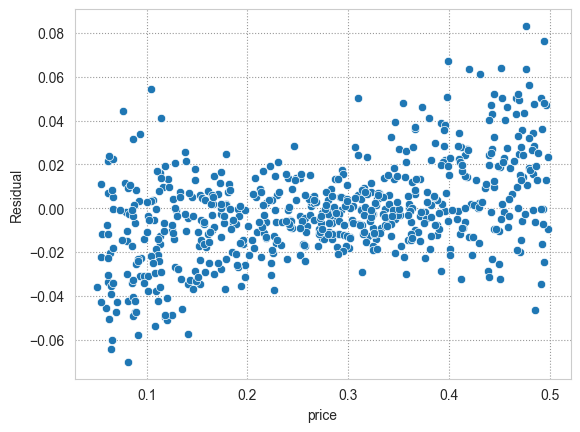

In [27]:
residuals = y_test - y_pred
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

## метод нейронных сетей

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - R2Score: -1.8806 - loss: 0.0475 - val_R2Score: 0.4103 - val_loss: 0.0098
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - R2Score: 0.5386 - loss: 0.0079 - val_R2Score: 0.7028 - val_loss: 0.0049
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - R2Score: 0.7536 - loss: 0.0042 - val_R2Score: 0.7695 - val_loss: 0.0038
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - R2Score: 0.8382 - loss: 0.0028 - val_R2Score: 0.8465 - val_loss: 0.0025
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - R2Score: 0.8804 - loss: 0.0020 - val_R2Score: 0.8814 - val_loss: 0.0020
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - R2Score: 0.9014 - loss: 0.0017 - val_R2Score: 0.8944 - val_loss: 0.0018
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - R2Score: 0.9292 - loss: 0.0012 - val_R2Score: 0.9162 - val_loss: 0.0014
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.9377 - loss: 0.0011 - val_R2Scor

<Axes: >

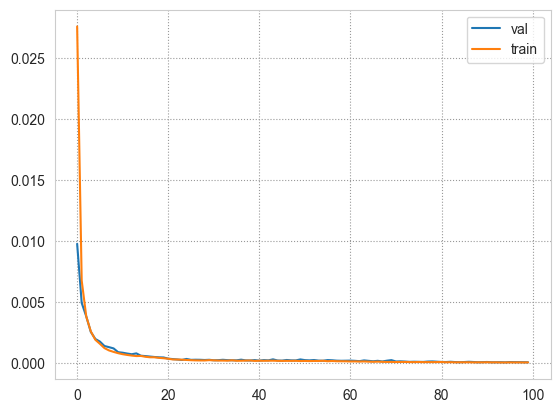

In [28]:
# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) 

# Компиляция модели
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['R2Score'])

# Обучение модели
epochs = 100
batch_size=8
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

# выводим графики
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


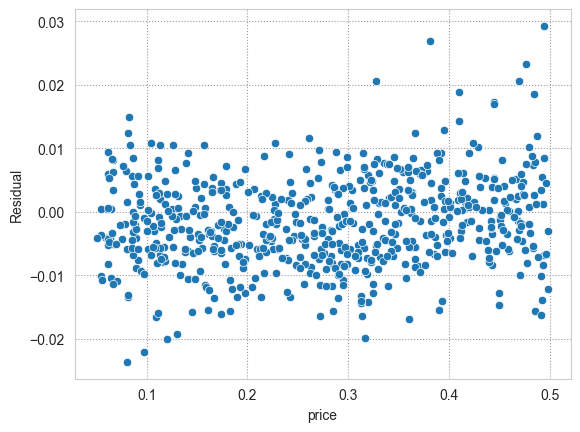

In [29]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()